In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

from __future__ import absolute_import, print_function
import matplotlib.pyplot as plt
import pyopencl as cl
import numpy as np
from cv2 import resize

## Inicializar contexto y cola de ejecución

In [2]:
ID_P = 0
ID_D = 0
platforms = cl.get_platforms()
devices = [platforms[ID_P].get_devices()[ID_D]]
context = cl.Context(devices=devices,properties=[(cl.context_properties.PLATFORM, platforms[ID_P])])
context.get_info(cl.context_info.DEVICES)
queue = cl.CommandQueue(context, properties=cl.command_queue_properties.OUT_OF_ORDER_EXEC_MODE_ENABLE)
queue.get_info(cl.command_queue_info.CONTEXT)

<pyopencl.Context at 0x562a96fe78e0 on <pyopencl.Device 'GeForce RTX 2080' on 'NVIDIA CUDA' at 0x562a97c50d40>>

## Código fuente y compilación del programa

https://en.wikipedia.org/wiki/Sobel_operator


In [3]:
source_file=open("sobel.c","r")

kernel = source_file.read()

source_file.close()

prg = cl.Program(context, kernel)
exe = prg.build(options=[])

## Cargar imagen de prueba

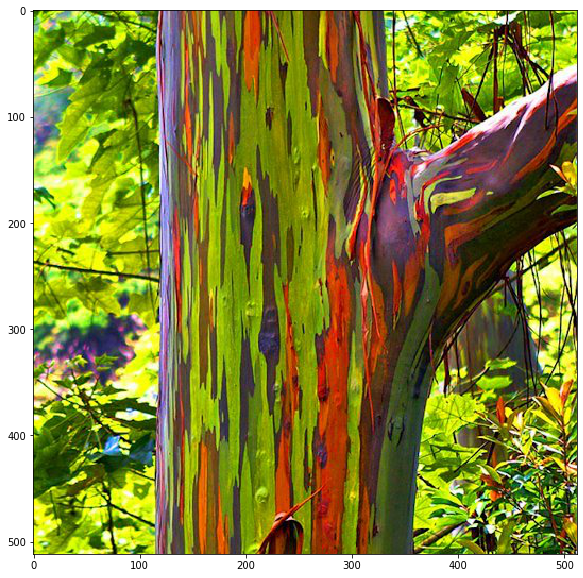

(3, 512, 512) float32


In [4]:
size=512
host_color = (plt.imread("tree.jpg")/255).astype(np.float32)
host_color = resize(host_color,(size,size))

plt.figure(figsize=(10,10))
plt.imshow(host_color,'gray')
plt.show()

host_color = np.transpose(host_color, [2, 0, 1]).copy()

print(host_color.shape,host_color.dtype )

## Inicialización de memoria y copia al dispositivo

In [5]:
device_color = cl.Buffer(context, cl.mem_flags.READ_WRITE, size=host_color.nbytes)
device_sobel = cl.Buffer(context, cl.mem_flags.READ_WRITE, size=host_color.nbytes)
cl.enqueue_copy(queue, device_color, host_color, is_blocking=False, wait_for=None)
cl.enqueue_fill_buffer(queue, device_sobel, pattern=np.float32(0),size=4,offset=0)

## Ejecución del kernel

0.0 0.46042198


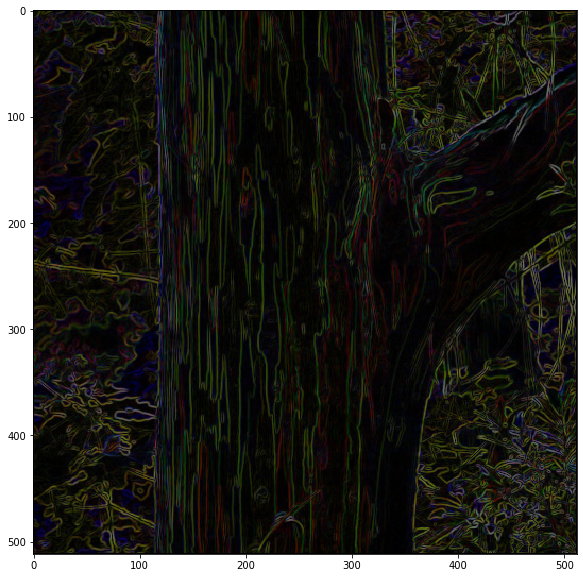

In [6]:

host_color.fill(0.)            
exe_event=exe.sobel(queue, (size-2,size-2,3), None, device_color, device_sobel, wait_for=None)
cl.enqueue_copy(queue, host_color, device_sobel, is_blocking=True, wait_for=None)

image = np.transpose(host_color, [1, 2, 0]).copy()


print(image.min(),image.max())

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()